首先安装并导入建模和后处理需要的包：

In [14]:
pip install ase

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [21]:
from ase.build import graphene_nanoribbon
from ase.io import write
from ase.visualize import view

创建石墨烯周期性结构：

In [16]:
gnr = graphene_nanoribbon(40, 10, type='armchair', sheet=True, vacuum=3.35/2)
gnr.euler_rotate(theta=90)
l = gnr.cell.lengths()
gnr.cell = gnr.cell.new((l[0], l[2], l[1]))
l = l[2]
gnr.center()
gnr.pbc = [True, True, False]
write("model.xyz", gnr)

借助ase对创建结构进行可视化（采用OVITO查看效果更佳）：

In [17]:
view(gnr, viewer='x3d')

复制碳的通用势函数进行分子动力学模拟：

In [18]:
ls ../task1_gpumd_install/GPUMD-3.9.4/potentials/*

../task1_gpumd_install/GPUMD-3.9.4/potentials/readme.md

../task1_gpumd_install/GPUMD-3.9.4/potentials/eam:
Cu_Dai_2006.txt               eam_zhou_2004_CoCrNi.txt
Cu_Zhou_2004.txt              eam_zhou_2004_CuFeNi.txt
eam_zhou_2004_18Elements.txt  eam_zhou_2004_Cu.txt
eam_zhou_2004_AlCoCuFeNi.txt  readme.md

../task1_gpumd_install/GPUMD-3.9.4/potentials/fcp:
Al/

../task1_gpumd_install/GPUMD-3.9.4/potentials/lj:
Ar_10A.txt  Ar_20A.txt

../task1_gpumd_install/GPUMD-3.9.4/potentials/nep:
C_2022_NEP3.txt  Si_2022_NEP2.txt
C_2024_NEP4.txt  Song-2024-UNEP-v1-AgAlAuCrCuMgMoNiPbPdPtTaTiVWZr.txt
readme.md

../task1_gpumd_install/GPUMD-3.9.4/potentials/tersoff:
BNC_Kinaci_2012.txt  Ge_Tersoff_1989.txt                 Si_Erhart_2005_2.txt
BN_Lindsay_2011.txt  Graphene_Lindsay_2010_modified.txt  Si_Fan_2019.txt
BN_Sevik_2011.txt    Graphene_Lindsay_2010.txt           SiO_Munetoh_2007.txt
C_Tersoff_1989.txt   readme.md                           Si_Tersoff_1989.txt
GaN_Nord_2003.txt    SiC_tersoff_

In [19]:
cp ../task1_gpumd_install/GPUMD-3.9.4/potentials/nep/C_2024_NEP4.txt .

ls

在shell环境下运行gpumd!

我们的第一个gpumd任务运行完成，现在我们输出应力应变曲线。首先加载画图的基本设置：

In [23]:
from pylab import *

aw = 2 
fs = 18 
lw = 3
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)
def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='out', right=False, top=False)

从gpumd热动力学物理量的输出文件thermo.out中提取我们所需要的应力应变结果并绘图

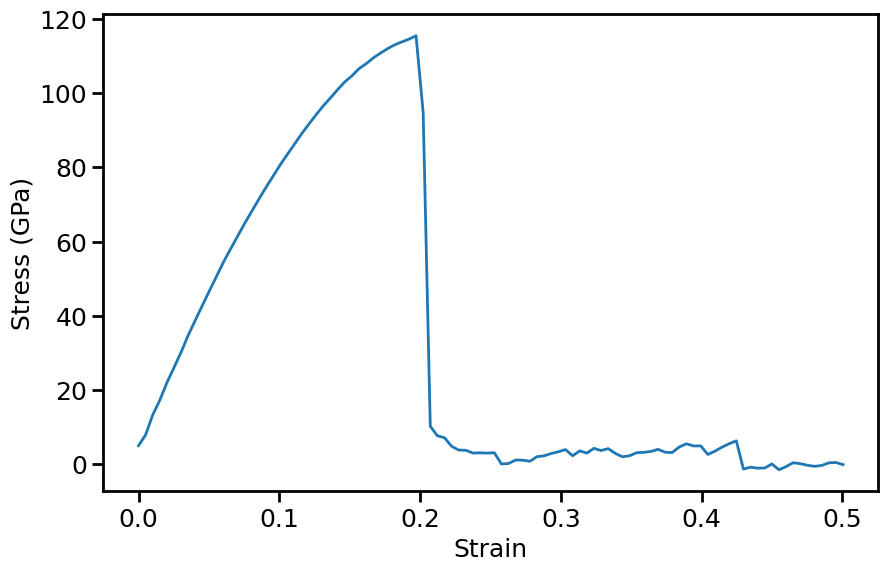

In [26]:
"""
Please check https://gpumd.org/gpumd/output_files/thermo_out.html

If the simulation box is orthogonal, there are 12 columns in this output 
file, each containing the values of a quantity at increasing time points:
    
column   1 2 3 4  5  6  7   8   9   10 11 12
quantity T K U Px Py Pz Pyz Pxz Pxy Lx Ly Lz"""

thermo_raw = np.loadtxt("thermo.out")

lx = thermo_raw[:, 9]
px = thermo_raw[:, 3]
strainx = lx / lx[0] -1 #definition of engineering strain
stressx = px * -1 #unit in GPa

figure(figsize=(10, 6.2))
set_fig_properties([gca()])
plot(strainx, stressx, lw=2)
xlabel(r'Strain')
ylabel(r'Stress (GPa)')
savefig("graphene_tension.png", bbox_inches='tight')

现在我们完成了第一个gpumd的模拟！感兴趣的话，我们可以与实验测量结果进行对比。但是请记住，这里只是一个测试的例子，用来熟悉怎么使用GPUMD模拟。一个可靠的模拟
结果需要确保势函数是准确的并进行多次模拟进行平均。此外，还需要测试模拟结果对系统尺寸大小和应变率的收敛。在之后的课程中，我们会展示这些因素如何影响二维材料的断裂性能。